In [1]:
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from covnet import *
from dataloader import *
from utils import *

import torch.nn as nn
import torchvision.models as models


import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'

In [2]:
import warnings
warnings.filterwarnings("ignore")

# Download Dataset

Please download the dataset using this [link](https://enacshare.epfl.ch/bY2wS5TcA4CefGks7NtXg). Put it in the root folder of this project, the following cell will unzip it correctly.


In [3]:
import zipfile

zip_filename = "canopy_height_dataset.zip"  
target_directory = "canopy_height_dataset" 

# Check if the ZIP file exists
if os.path.exists(zip_filename):
    # Check if the target directory already exists
    if os.path.exists(target_directory):
        print(f"Directory '{target_directory}' already exists. Skipping extraction.")
    else:
        try:
            # Unzip the file
            with zipfile.ZipFile(zip_filename, 'r') as zip_ref:
                zip_ref.extractall('.')  # Extract to the root directory ('.')
            print(f"Files successfully extracted to the root directory.")
        except zipfile.BadZipFile:
            print("Error: The file is not a valid ZIP file.")
else:
    print(f"Error: The file '{zip_filename}' does not exist in the current directory.")

Directory 'canopy_height_dataset' already exists. Skipping extraction.


## Now lets get serious

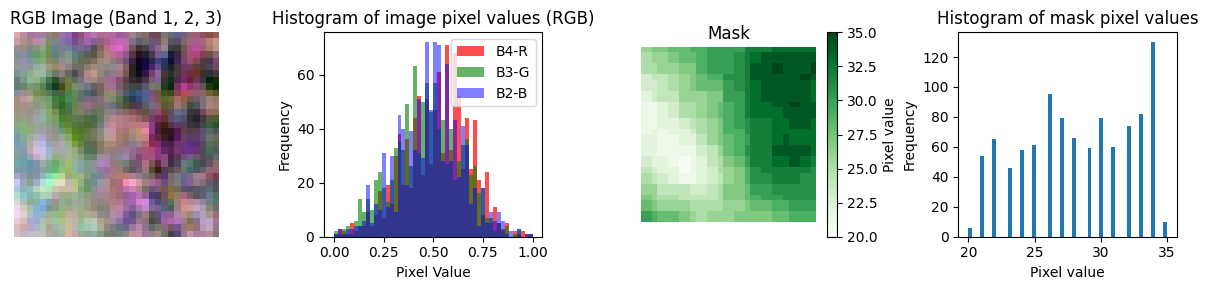

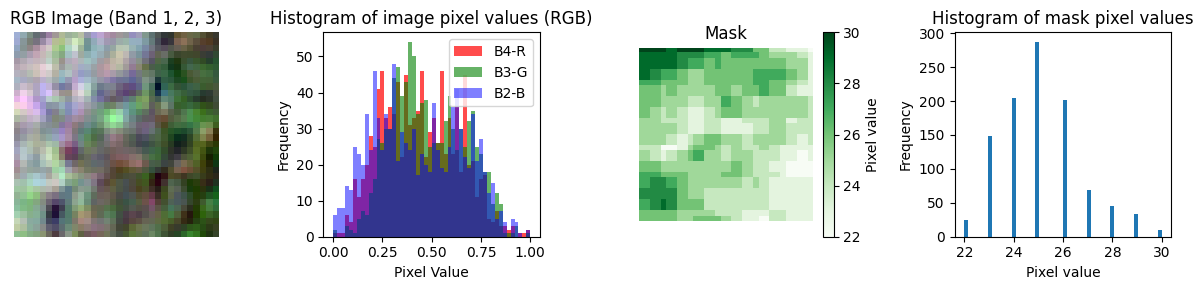

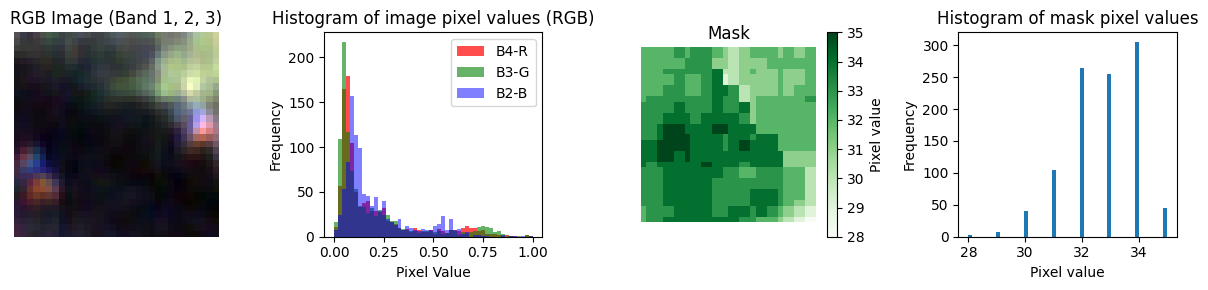

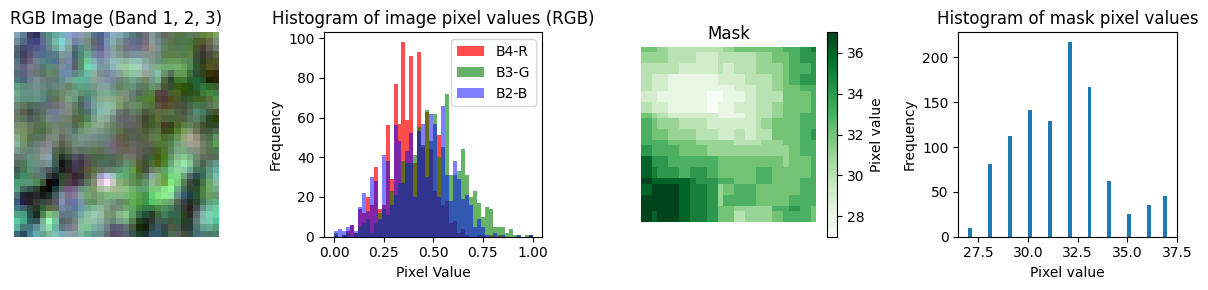

In [4]:
csv_path = "canopy_height_dataset/data_split.csv" #change this path if you import data differently 

# Load and create the dataloader
train_dl = Sentinel2(csv_path=csv_path, split="train", RGB=False)
train_loader = DataLoader(train_dl, batch_size=4, shuffle=False)

# Call the first batch
images, masks = next(iter(train_loader))

#Show the first 4 images of the train set
for i in range(0,images.shape[0]):
    image = images[i].numpy()
    mask = masks[i].numpy()
    show_image_histogram_mask(image, mask)

In [5]:
#instantiate the transformation
transforms_train = TransformCustom12(augmentations=[
  RandomHorizontalFlip(p=0.5),
  RandomVerticalFlip(p=0.5),
  RandomRotation(angles=(90,180,270), p=0.5)
])

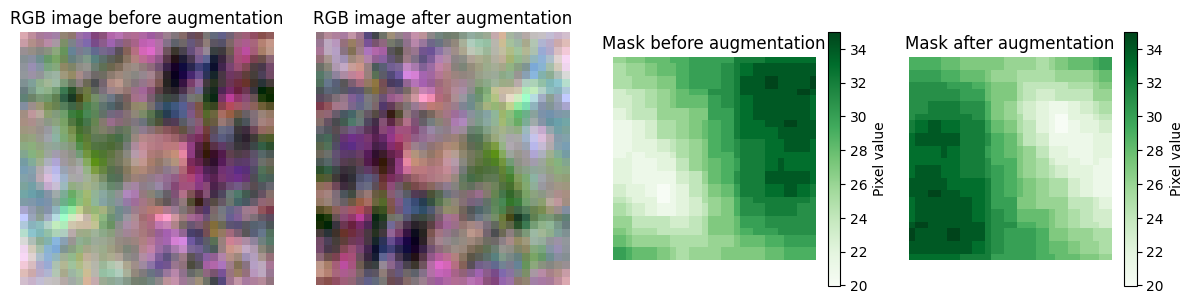

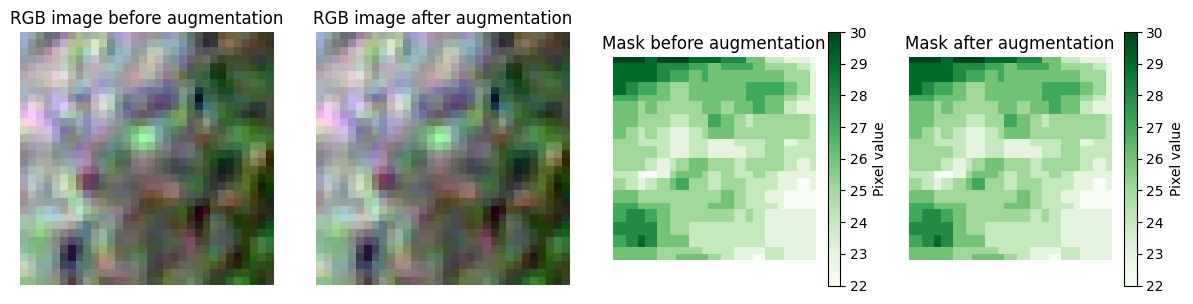

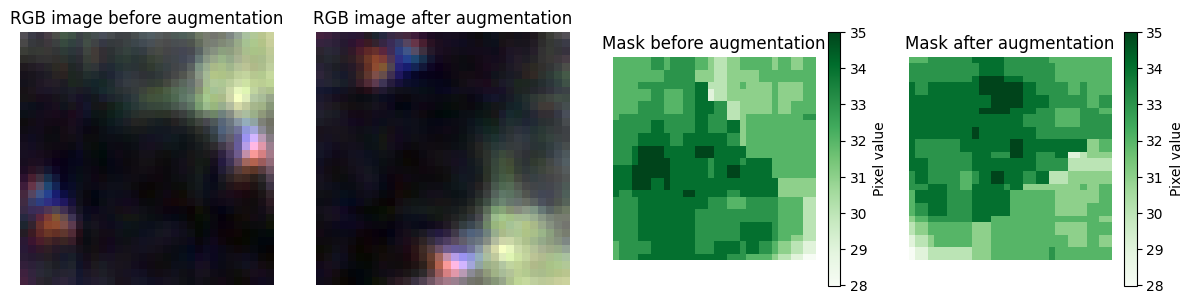

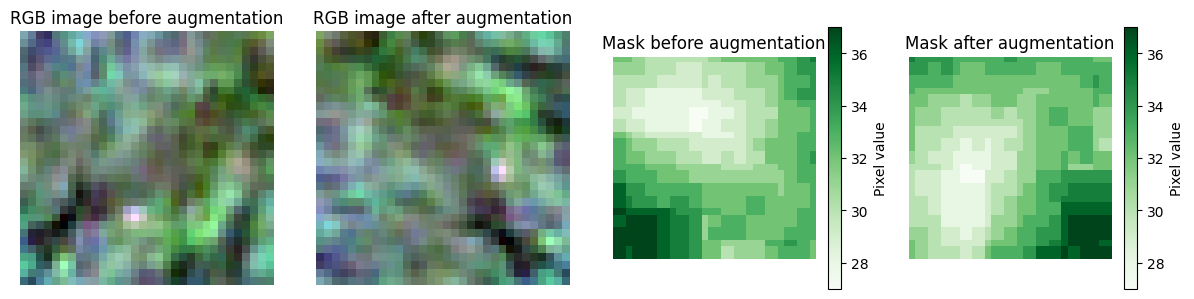

In [6]:
#keep shuffle = False to make sure the images are called in ascending order and always the same
#load and create the dataloader with transformation
train_trandform_dl = Sentinel2(csv_path=csv_path, split="train",transform=transforms_train, RGB=False)
train_transform_loader = DataLoader(train_trandform_dl, batch_size=4, shuffle=False)

#load and create the dataloader without transformation
train_dl = Sentinel2(csv_path=csv_path, split="train",transform=None)
train_loader = DataLoader(train_dl, batch_size=4, shuffle=False)
 
images_before, masks_before = next(iter(train_loader))
images_after, masks_after = next(iter(train_transform_loader))

for i in range(0,images_before.shape[0]):
    image_before = images_before[i].numpy()
    mask_before = masks_before[i].numpy()

    image_after = images_after[i].numpy()
    mask_after = masks_after[i].numpy()

    show_before_after_augmentation(image_before, image_after, mask_before, mask_after)

In [7]:
## Show the prediction and the RMSE, MAE of the test set
#call the dataloader for RGB on the test set
test_RGB_dl = Sentinel2(csv_path=csv_path, split="test", RGB=True)
test_RGB_loader = DataLoader(test_RGB_dl, batch_size=16, shuffle=False)

#call the dataloader for 12 bands on the test set
test_12_dl = Sentinel2(csv_path=csv_path, split="test", RGB=False)
test_12_loader = DataLoader(test_12_dl, batch_size=16, shuffle=False)

# call the first batch - batch size = 16 to show different prediction
images_RGB, masks = next(iter(test_RGB_loader))
images_12, _ = next(iter(test_12_loader))

# pass the images and masks to 'cuda'
images_RGB = images_RGB.to('cuda')
images_12 = images_12.to('cuda')
masks = masks.to('cuda')

#### load and instantiate the different models
path_12_DA = 'Models/model_12bands_Aug_lr0.001_wd1e-05.pth'
path_12_nDA = 'Models/model_12bands_NotAug_lr0.001_wd1e-05.pth'
path_RGB_DA = 'Models/model_3bands_Aug_lr0.001_wd1e-05.pth'
path_RGB_nDA = 'Models/model_3bands_NotAug_lr0.001_wd1e-05.pth'

### ResNet101 ###
resnet101 = models.resnet101(pretrained = True)
resnet101.fc = nn.Sequential(
    nn.Linear(resnet101.fc.in_features, 32 * 32),
    nn.Unflatten(1, (1, 32, 32)) 
)

### Model 12-DA ###
model12_DA = UNetRegressor(in_channels=images_12.shape[1], out_channels=1)
model12_DA.load_state_dict(torch.load(path_12_DA))

### Model 12-noDA ###
model12_nDA = UNetRegressor(in_channels=images_12.shape[1], out_channels=1)
model12_nDA.load_state_dict(torch.load(path_12_nDA))

### Model RGB-DA ###
modelRGB_DA = UNetRegressor(in_channels=images_RGB.shape[1], out_channels=1)
modelRGB_DA.load_state_dict(torch.load(path_RGB_DA))

### Model RGB-nDA ###
modelRGB_nDA = UNetRegressor(in_channels=images_RGB.shape[1], out_channels=1)
modelRGB_nDA.load_state_dict(torch.load(path_RGB_nDA))

## pass the models to 'cuda'
resnet101 = resnet101.to('cuda')
model12_DA = model12_DA.to('cuda')
model12_nDA = model12_nDA.to('cuda')
modelRGB_DA = modelRGB_DA.to('cuda')
modelRGB_nDA = modelRGB_nDA.to('cuda')

# set the model in evaluation mode to predict on the test set
resnet101.eval()
model12_DA.eval()
model12_nDA.eval()
modelRGB_DA.eval()
modelRGB_nDA.eval()

# prediction of the 5 models on the test set
with torch.no_grad():
    outputs_resnet101 = resnet101(images_RGB)
    outputs_12_DA = model12_DA(images_12)
    outputs_12_nDA = model12_nDA(images_12)
    outputs_RGB_DA = modelRGB_DA(images_RGB)
    outputs_RGB_nDA = modelRGB_nDA(images_RGB) 

# pass the predictions to 'cpu' and convert in numpy to show it 
outputs_resnet101 = outputs_resnet101.to('cpu').numpy()
outputs_12_DA = outputs_12_DA.to('cpu').numpy()
outputs_12_nDA = outputs_12_nDA.to('cpu').numpy()
outputs_RGB_DA = outputs_RGB_DA.to('cpu').numpy()
outputs_RGB_nDA = outputs_RGB_nDA.to('cpu').numpy()
masks = masks.to('cpu').numpy()

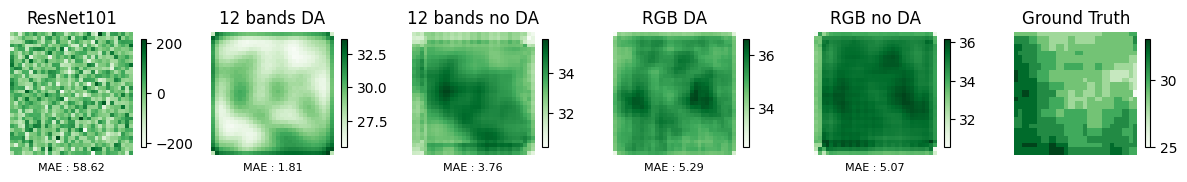

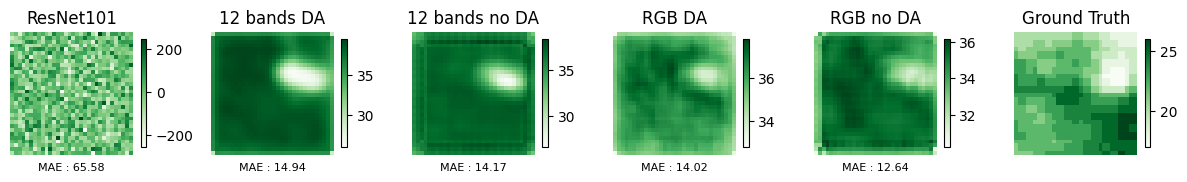

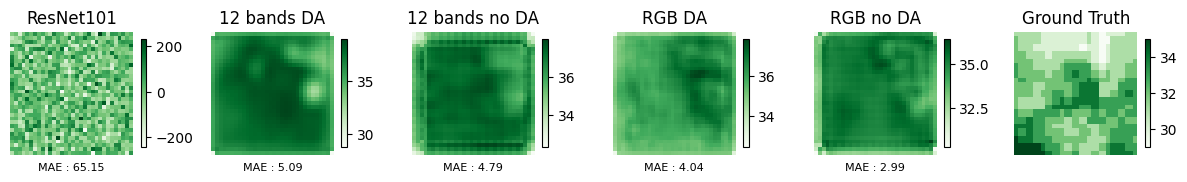

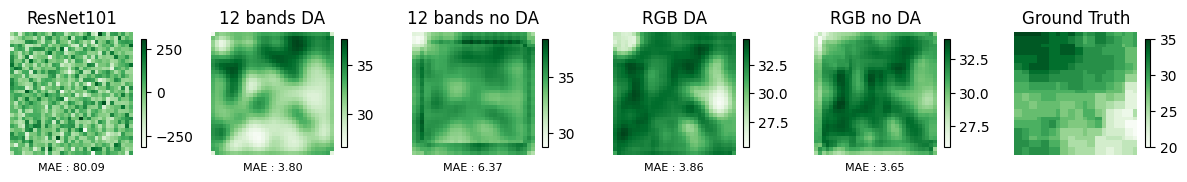

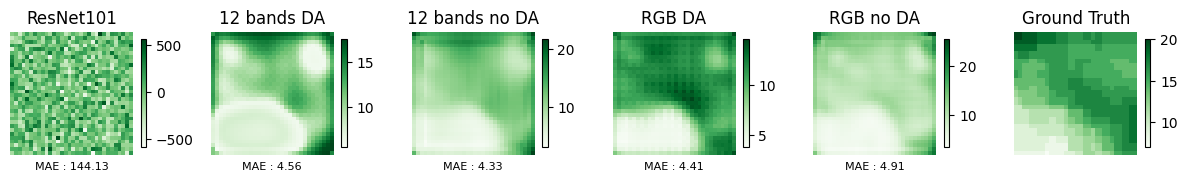

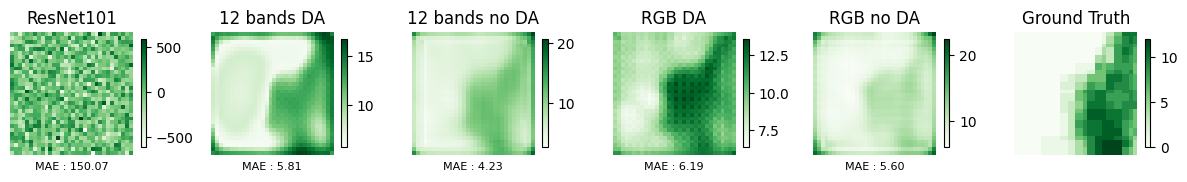

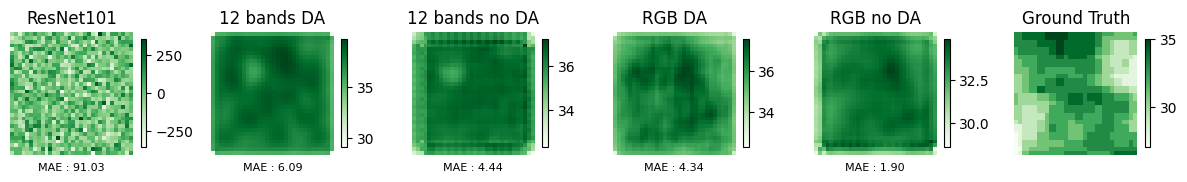

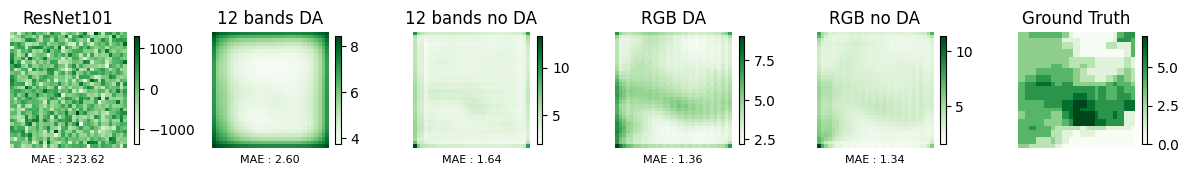

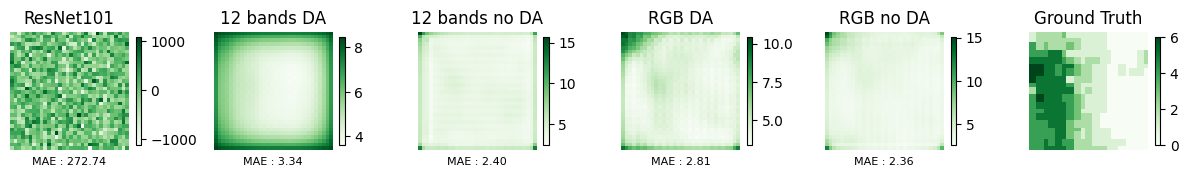

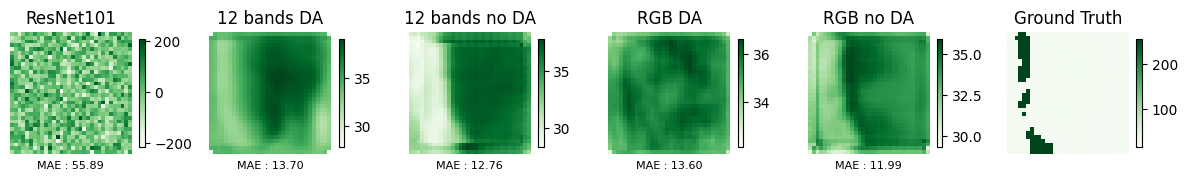

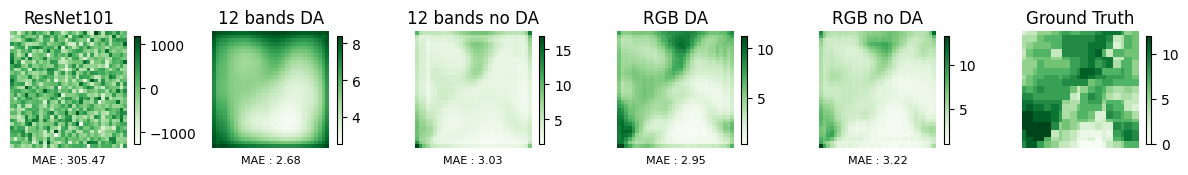

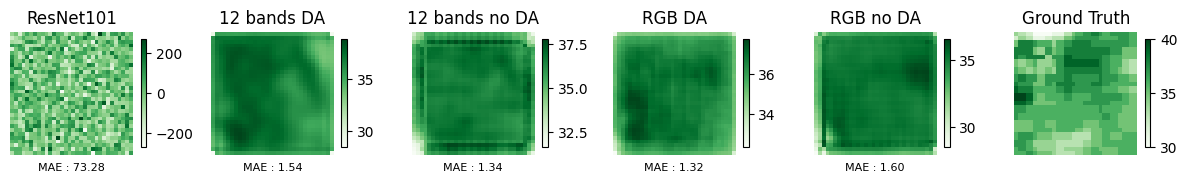

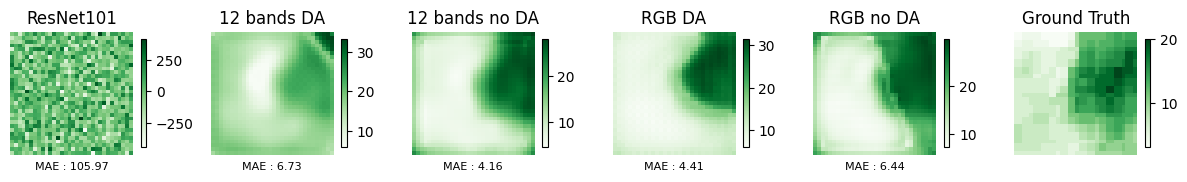

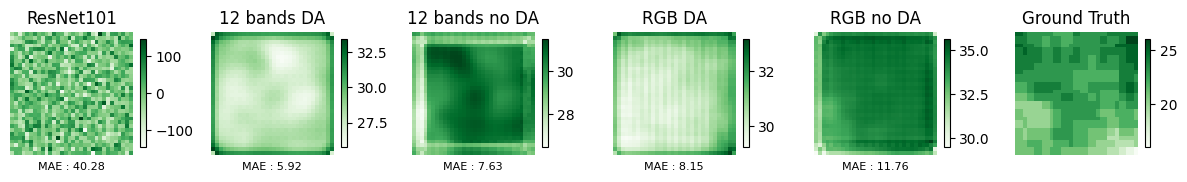

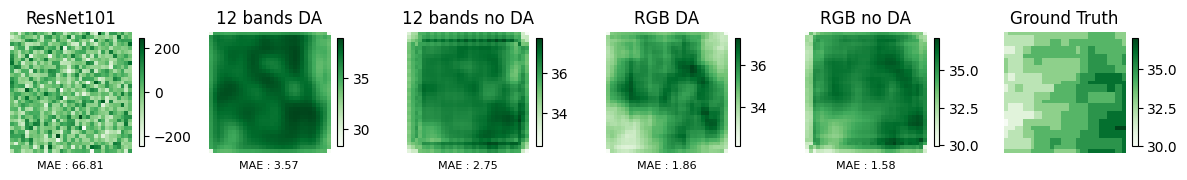

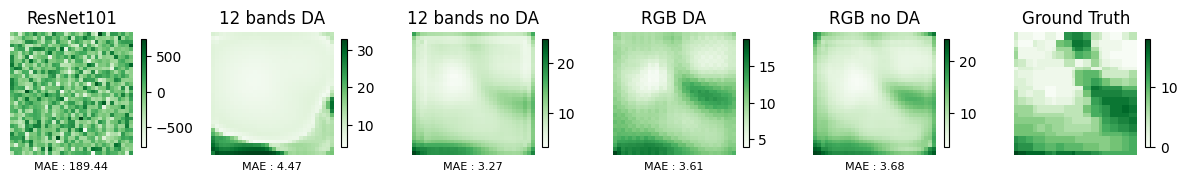

In [8]:
# showing the prediction and compare with the mask (Ground Truth)
## Watch out to the color scale it is different for each predicition
for i in range (0,outputs_resnet101.shape[0]):
    show_pred_mask(outputs_resnet101[i], outputs_12_DA[i], outputs_12_nDA[i], outputs_RGB_DA[i], outputs_RGB_nDA[i], masks[i]) # rajouter un paramètre [MAE1, MAE2, ...]

In [9]:
## Final test to get MAE and RMSE

# call the dataloader for the test split, for 12 bands and RGB
test_RGB_dl = Sentinel2(csv_path=csv_path, split="test", RGB=True)
test_RGB_loader = DataLoader(test_RGB_dl, batch_size=256, shuffle=True) 

test_12_dl = Sentinel2(csv_path=csv_path, split="test", RGB=False)
test_12_loader = DataLoader(test_12_dl, batch_size=256, shuffle=True)

# instantiate 2 different criterion used as metrics
criterion = nn.MSELoss(reduction = 'none') #MSE metric
criterion2 = nn.L1Loss(reduction = 'none') #MAE metric

#### Calculate RMSE and MAE on 12 bands ###
# Using 2 models, one data augmented (12_DA) and one not (12_nDA)
final_loss_12_DA = 0.0
final_loss_12_nDA = 0.0
final_loss_12_DA_MAE = 0.0
final_loss_12_nDA_MAE = 0.0

model12_DA.eval()
model12_nDA.eval()
with torch.no_grad():
    for batch_idx, (images, masks) in enumerate(test_12_loader):
        images = images.to('cuda')
        masks = masks.to('cuda')
        
        outputs_12_DA = model12_DA(images)
        outputs_12_nDA = model12_nDA(images)

        loss_map_12_DA = criterion(outputs_12_DA, masks)
        loss_map_12_nDA = criterion(outputs_12_nDA, masks)

        loss_map_12_DA_MAE = criterion2(outputs_12_DA, masks)
        loss_map_12_nDA_MAE = criterion2(outputs_12_nDA, masks)
        
        valid_mask = (masks != 255).float()
        valid_loss_map_12_DA = loss_map_12_DA*valid_mask
        valid_loss_map_12_nDA = loss_map_12_nDA*valid_mask

        valid_loss_map_12_DA_MAE = loss_map_12_DA_MAE*valid_mask
        valid_loss_map_12_nDA_MAE = loss_map_12_nDA_MAE*valid_mask


        num_valid_pixels = valid_mask.sum()
        loss_12_DA = valid_loss_map_12_DA.sum() / num_valid_pixels
        loss_12_nDA = valid_loss_map_12_nDA.sum()/num_valid_pixels

        loss_12_DA_MAE = valid_loss_map_12_DA_MAE.sum() / num_valid_pixels
        loss_12_nDA_MAE = valid_loss_map_12_nDA_MAE.sum()/num_valid_pixels

        final_loss_12_DA += loss_12_DA.item()
        final_loss_12_nDA += loss_12_nDA.item()

        final_loss_12_DA_MAE += loss_12_DA_MAE.item()
        final_loss_12_nDA_MAE += loss_12_nDA_MAE.item()

final_loss_12_DA /= len(test_12_loader)
rmse_12_DA = torch.sqrt(torch.tensor(final_loss_12_DA))

final_loss_12_nDA /= len(test_12_loader)
rmse_12_nDA = torch.sqrt(torch.tensor(final_loss_12_nDA))

final_loss_12_DA_MAE /= len(test_12_loader)
final_loss_12_nDA_MAE /= len(test_12_loader)

print(f"Test rmse 12 bandes DA: {rmse_12_DA:.4f} and MAE: {final_loss_12_DA_MAE:.4f}")
print(f"Test rmse 12 bandes no DA: {rmse_12_nDA:.4f} and MAE: {final_loss_12_nDA_MAE:.4f}")


#### Calculate RMSE and MAE on RGB bands ###
# Using 3 models, one handmade data augmented (RGB_DA) and one not (RGB_nDA), and the ResNet101
final_loss_resnet101 = 0.0
final_loss_RGB_DA = 0.0
final_loss_RGB_nDA = 0.0
final_loss_RGB_DA_MAE = 0.0
final_loss_RGB_nDA_MAE = 0.0
final_loss_resnet101_MAE = 0.0

resnet101.eval()
modelRGB_DA.eval()
modelRGB_nDA.eval()
with torch.no_grad():
    for batch_idx, (images, masks) in enumerate(test_RGB_loader):
        images = images.to('cuda')
        masks = masks.to('cuda')
        
        outputs_RGB_DA = modelRGB_DA(images)
        outputs_RGB_nDA = modelRGB_nDA(images)
        outputs_resnet101 = resnet101(images)

        loss_map_RGB_DA = criterion(outputs_RGB_DA, masks)
        loss_map_RGB_nDA = criterion(outputs_RGB_nDA, masks)
        loss_map_resnet101 = criterion(outputs_resnet101, masks)

        loss_map_RGB_DA_MAE = criterion2(outputs_RGB_DA, masks)
        loss_map_RGB_nDA_MAE = criterion2(outputs_RGB_nDA, masks)
        loss_map_resnet101_MAE = criterion2(outputs_resnet101, masks)
        
        valid_mask = (masks != 255).float()
        valid_loss_map_RGB_DA = loss_map_RGB_DA*valid_mask
        valid_loss_map_RGB_nDA = loss_map_RGB_nDA*valid_mask
        valid_loss_map_resnet101 = loss_map_resnet101*valid_mask

        valid_loss_map_RGB_DA_MAE = loss_map_RGB_DA_MAE*valid_mask
        valid_loss_map_RGB_nDA_MAE = loss_map_RGB_nDA_MAE*valid_mask
        valid_loss_map_resnet101_MAE = loss_map_resnet101_MAE*valid_mask

        num_valid_pixels = valid_mask.sum()
        loss_RGB_DA = valid_loss_map_RGB_DA.sum() / num_valid_pixels
        loss_RGB_nDA = valid_loss_map_RGB_nDA.sum()/num_valid_pixels
        loss_resnet101 = valid_loss_map_resnet101.sum()/num_valid_pixels

        loss_RGB_DA_MAE = valid_loss_map_RGB_DA_MAE.sum() / num_valid_pixels
        loss_RGB_nDA_MAE = valid_loss_map_RGB_nDA_MAE.sum()/num_valid_pixels
        loss_resnet101_MAE = valid_loss_map_resnet101_MAE.sum()/num_valid_pixels

        final_loss_RGB_DA += loss_RGB_DA.item()
        final_loss_RGB_nDA += loss_RGB_nDA.item()
        final_loss_resnet101 += loss_resnet101.item()

        final_loss_RGB_DA_MAE += loss_RGB_DA_MAE.item()
        final_loss_RGB_nDA_MAE += loss_RGB_nDA_MAE.item()
        final_loss_resnet101_MAE += loss_resnet101_MAE.item()

final_loss_RGB_DA /= len(test_RGB_loader)
rmse_RGB_DA = torch.sqrt(torch.tensor(final_loss_RGB_DA))

final_loss_RGB_nDA /= len(test_12_loader)
rmse_RGB_nDA = torch.sqrt(torch.tensor(final_loss_RGB_nDA))

final_loss_resnet101 /= len(test_12_loader)
rmse_resnet101 = torch.sqrt(torch.tensor(final_loss_resnet101))

final_loss_RGB_DA_MAE /= len(test_RGB_loader)
final_loss_RGB_nDA_MAE /= len(test_RGB_loader)
final_loss_resnet101_MAE /= len(test_12_loader)

print(f"Test rmse RGB bandes DA: {rmse_RGB_DA:.4f}  and MAE: {final_loss_RGB_DA_MAE:.4f}")
print(f"Test rmse RGB bandes no DA: {rmse_RGB_nDA:.4f}  and MAE: {final_loss_RGB_nDA_MAE:.4f}")
print(f"Test rmse ResNet101: {rmse_resnet101:.4f}  and MAE: {final_loss_resnet101_MAE:.4f}")



Test rmse 12 bandes DA: 6.4980 and MAE: 5.2987
Test rmse 12 bandes no DA: 6.0964 and MAE: 4.8486
Test rmse RGB bandes DA: 6.1694  and MAE: 4.8515
Test rmse RGB bandes no DA: 5.5800  and MAE: 4.2556
Test rmse ResNet101: 214.4993  and MAE: 136.1943
